<a href="https://colab.research.google.com/github/artemponomarevjetski/Invoke-RESTAPI/blob/master/tqqq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

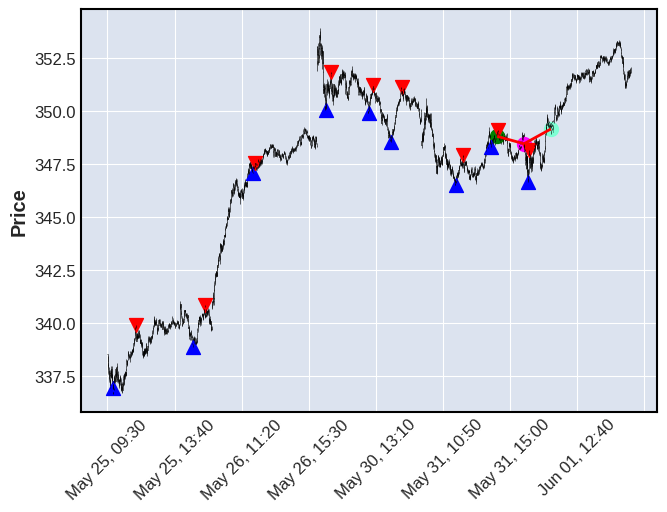

/usr/local/lib/python3.10/dist-packages/mplfinance/_arg_validators.py:83: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sun Apr  9 18:48:45 2023

@author: artemponomarev
"""
!pip install mplfinance

import os
from datetime import datetime, timedelta

from google.colab import drive
from IPython.display import clear_output
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import mplfinance as mpf
import numpy as np
import pandas as pd
import yfinance as yf

drive.mount('/content/drive')

ndays = 5 # Number of trading days in a week
# Define the ticker symbol
symbol = 'QQQ'

def test_pivot_properties(forward_pivots):
    """
    Test properties of pivot points.

    Args:
        forward_pivots (list): List of forward pivot points.
    """
    for pivot in forward_pivots:
        assert pivot[0][0] == 'bottom', f"First element of the first tuple should be 'bottom'. pivot: {pivot}"
        assert pivot[1][0] == 'top', f"First element of the second tuple should be 'top'. pivot: {pivot}"
        try:
            assert pivot[0][2] > pivot[1][2], f"Third element of the first tuple should be less than the third element of the second tuple. pivot: {pivot}"
        except AssertionError as e:
            print(e)
            raise
        try:
            assert pivot[0][3] < pivot[1][3], f"Fourth element of the first tuple should be less than the fourth element of the second tuple. pivot: {pivot}"
        except AssertionError as e:
            print(e)
            raise

def find_pivots(i, j, lagging_pivots, rank):
    """
    Find pivot points.

    Args:
        i (int): Index i.
        j (int): Index j.
        lagging_pivots (list): List of lagging pivot points.
        rank (int): Rank of pivot point.

    Returns:
        tuple: Bottom and top pivot points.
    """
    top, bottom = None, None
    for k, el in enumerate(lagging_pivots[j]):
        if k <= rank or not el[2] or el[2] > i:
            continue
        if el[0] == 'top' and not top:
            top = tuple(el)
        elif el[0] == 'bottom' and top and not bottom:
            bottom = tuple(el)
        elif top and bottom:
            break
    return bottom, top

# Define the trading session time
start_time = datetime.strptime('09:30', '%H:%M').time()
end_time = datetime.strptime('16:00', '%H:%M').time()

# Get the total number of minutes in the trading session
total_minutes_one_session = (end_time.hour - start_time.hour) * 60 + (end_time.minute - start_time.minute)

# Define the time period for the data
time_period = ''.join([str(5*ndays), 'd'])

# Download the data
data = yf.download(symbol, period=time_period, interval='1d')

# Calculate the number of trading days
num_trading_days = 0
trading_dates = []
for day in reversed(data.index.date):
    if num_trading_days == 0: # Day 0 may be in the middle of a trading session
        num_trading_days += 1
        continue
    elif num_trading_days == 1:
        end_date = day
        trading_dates.append(day)
    elif num_trading_days > 5:
      break
    else:
       trading_dates.append(day)
       start_date = day
    num_trading_days += 1

print('These are the last five trading dates:', pd.to_datetime(trading_dates))
print(f'There are {num_trading_days-1} trading days in the data from {start_date} to {end_date}')

# Download the data for each trading day and save in a separate CSV file
days_data_path = os.path.join('/content', 'drive', 'My Drive', 'Colab Notebooks', 'daysdata')
os.makedirs(days_data_path, exist_ok=True)
for day in trading_dates:
    # Download the data
    day_data = yf.download(symbol, start=day, end=day+timedelta(days=1), interval='1m')
    day_data.to_csv(os.path.join(days_data_path, f'{symbol}-{day}.csv'))

csv_files = [os.path.join(days_data_path, f) for f in os.listdir(days_data_path) if f.startswith(symbol) and f.endswith('.csv')]
csv_files_sorted = sorted(csv_files)
print('All CSV files:', csv_files_sorted)

data1 = pd.DataFrame()
nday = 0
print(csv_files_sorted)
for file in reversed(csv_files_sorted):
    # Load the data from the CSV file
    temp_data = pd.read_csv(file, index_col=0, parse_dates=True)
    # Concatenate the data into a single DataFrame
    data1 = pd.concat([data1, temp_data.iloc[::-1]])
    nday += 1
    if nday == ndays:
        break

print(f'{ndays} days of data is ingested...')      
print('Data columns =', data1.columns)

# Convert the index to datetime format
data1.index = pd.to_datetime(data1.index)

# Get the total number of minutes in 5 days
total_minutes = data1.shape[0]
print(f'There are {total_minutes} minutes in the data out of {ndays*total_minutes_one_session}')
data1.to_csv('/content/drive/My Drive/Colab Notebooks/temp.csv')
print(f'Last index of data1: {data1.index[-1]}')

# Define marker styles and colors
marker_style = ['^', 'v']
marker_color = ['#008000', '#FF0000', '#0000FF', '#800080', '#FFA500', '#00FFFF', '#FF00FF', '#808080', '#00FF00', '#000080']
# Here's what each color code represents:
# #008000: Green
# #FF0000: Red
# #0000FF: Blue
# #800080: Purple
# #FFA500: Orange
# #00FFFF: Cyan
# #FF00FF: Magenta
# #808080: Gray
# #00FF00: Lime
# #000080: Navy

lagging_pivots = []
for i in range(len(data1)-1): # First row of data is the present
    max_index_gl_max = np.where(np.array(data1['High'][i:]) == np.max(data1['High'][i:]))[0][0] + i
    max_index_gl_min = np.where(np.array(data1['Low'][i:]) == np.min(data1['Low'][i:]))[0][0] + i
    j = max(max_index_gl_max, max_index_gl_min)

    rank = 0 
    pivots = []
    if j == max_index_gl_min:
        pivots.append(['bottom', rank, j, data1.iloc[j]['Close']])    
        rank += 1
    else: 
        pivots.append(['top', rank, j, data1.iloc[j]['Close']])     
        rank += 1

    if j > i:
        while True:
            if pivots[-1][0] == 'bottom':
                # Find new top
                j = np.where(np.array(data1['High'][i:j]) == np.max(data1['High'][i:j]))[0][0] + i
                if j == i:
                    break
                top_close_price = data1.iloc[j]['High']
                # Check if 'top' is higher than the preceding 'bottom'
                pivots.append(['top', rank, j, top_close_price])   
                rank += 1
            elif pivots[-1][0] == 'top':
                # Find new bottom
                j = np.where(np.array(data1['Low'][i:j]) == np.min(data1['Low'][i:j]))[0][0] + i
                if j == i:
                    break
                bottom_close_price = data1.iloc[j]['Low']
                pivots.append(['bottom', rank, j, bottom_close_price])
                rank += 1

    pivots = list(reversed(pivots)) # Reverse pivots
    if len(pivots) >= 10:
        pivots = pivots[:10] # Keep the first 10 elements

    padding = [['padding', None, None, None]] * (10 - len(pivots))
    pivots += padding

    # Renumber ranks
    for index, pivot in enumerate(pivots):
        if pivot[0] != 'padding':
            pivot[1] = index

    lagging_pivots.append(pivots)

forward_pivots = set()
for i in range(len(data1)-1, 1, -1):
    for j in range(i-1, 1, -1):
        bottom, top = find_pivots(i, j, lagging_pivots, rank=3)
        if top and bottom:
            forward_pivots.add((bottom, top))
            break

forward_pivots = sorted(list(forward_pivots), key=lambda x: x[0][2])

# Apply the test
test_pivot_properties(forward_pivots)

# Create addplot objects for the markers
addplots = []
for pivot in forward_pivots:
    el = pivot[0]
    markers = np.full(data1.shape[0], np.nan)
    markers[len(data1)-int(el[2])] = el[3]
    markers_df = pd.DataFrame({'markers': markers}, index=data1.index)
    ap = mpf.make_addplot(markers_df, type='scatter', markersize=100, marker=marker_style[0], color='blue')
    addplots.append(ap)

    el = pivot[1]
    markers = np.full(data1.shape[0], np.nan)
    markers[len(data1)-int(el[2])] = el[3]
    markers_df = pd.DataFrame({'markers': markers}, index=data1.index)
    ap = mpf.make_addplot(markers_df, type='scatter', markersize=100, marker=marker_style[1], color='red')
    addplots.append(ap)

# Historical data and markers
mpf.plot(data1[::-1], type='candle', volume=False, addplot=addplots)

for i in range (len(data1)-1, 1,-1):
  addplots1 = []
  pointCurrent = None  # Array to store the coordinates of the points
  pointBottom  = None
  pointTop = None

  # Add the initial marker
  markers = np.full(data1.shape[0], np.nan)
  markers[len(data1)-i-1] = data1.iloc[i]['Close']
  pointCurrent = ((len(data1)-i-1, data1.iloc[i]['Close']))
  markers_df = pd.DataFrame({'markers': markers}, index=data1.index)
  ap = mpf.make_addplot(markers_df, type='scatter', markersize=100, marker='o', color='green')
  addplots1.append(ap)

  forward_bottom_pivot = 100
  forward_top_pivot = 200
  adjfactorbottom = 0.999
  adjfactortop = 1.001

  # Add the other markers with connecting lines
  if 0 <= len(data1)-i-1 + forward_bottom_pivot < len(data1):
      markers = np.full(data1.shape[0], np.nan)
      markers[len(data1)-i-1 + forward_bottom_pivot] = data1.iloc[i]['Close'] * adjfactorbottom
      pointBottom = ((len(data1)-i-1 + forward_bottom_pivot, data1.iloc[i]['Close'] * adjfactorbottom))
      markers_df = pd.DataFrame({'markers': markers}, index=data1.index)
      ap = mpf.make_addplot(markers_df, type='scatter', markersize=100, marker='o', color='magenta')
      addplots1.append(ap)

  if 0 <= len(data1)-i-1 + forward_top_pivot < len(data1):
      markers = np.full(data1.shape[0], np.nan)
      markers[len(data1)-i-1 + forward_top_pivot] = data1.iloc[i]['Close'] * adjfactortop
      pointTop = ((len(data1)-i-1 + forward_top_pivot, data1.iloc[i]['Close'] * adjfactortop))
      markers_df = pd.DataFrame({'markers': markers}, index=data1.index)
      ap = mpf.make_addplot(markers_df, type='scatter', markersize=100, marker='o', color='aquamarine')
      addplots1.append(ap)

  # Plot everything at once
  if pointCurrent and pointBottom and pointTop:
    fig, axes = mpf.plot(data1[::-1], type='candle', volume=False, returnfig=True, addplot=addplots1+addplots)
    lines = [
        [pointCurrent, pointBottom],  # line 1
        [pointBottom, pointTop],  # line 2
    ]
    lc = LineCollection(lines, colors='red')

    # Add the LineCollection to the axes
    axes[0].add_collection(lc)

    clear_output(wait=True)
    plt.show()

# Save graph to *.png
mpf.plot(data1[::-1], type='candle', style='charles', addplot=addplots, savefig='/content/drive/My Drive/Colab Notebooks/graph.png')